Test code to generate a multifasta

In [1]:
import proteomics.sequence as sequence
import urllib3
import json
import numpy as np
import collections
import CGAT.IOTools as IOTools
import CGAT.FastaIterator as FA

import pandas as pd
import os

import subprocess

from ete3 import NCBITaxa, TreeStyle
import sys

import string

%load_ext rpy2.ipython

In [2]:
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

Done. Parsing...


Loading node names...
1584874 names loaded.
186758 synonyms loaded.
Loading nodes...
1584874 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/FILESERVER5/proteomics/tss38/.etetoolkit/taxa.sqlite ...
 1584000 generating entries... 
Uploading to /home/FILESERVER5/proteomics/tss38/.etetoolkit/taxa.sqlite


Inserting synonyms:      20000 

Inserting synonyms:      185000 

Inserting taxids:       20000 

Inserting taxids:       1580000 

In [3]:
tetrapod_tax_id = 32523
vertebrate_tax_id = 7742
mammals_tax_id = 40674
placentals_tax_id = 9347
rodent_tax_id = 9989
eukaryote_tax_id = 2759

mouse_tax_id = 10090

In [4]:
print(ncbi.get_common_names([10090]))

{10090: 'house mouse'}


In [5]:
OGs_inf = "../raw/odb9v1_OGs_corrected.tab"
OG2genes_inf = "../raw/odb9v1_OG2genes.tab.gz"
genes_inf = "../raw/odb9v1_genes.tab"


In [6]:
uniprot_ids = []
outfile = "./results/multifasta.fa"
outfile_aligned = "./results/multifasta_clustalo.fa"


In [7]:
tax_id = vertebrate_tax_id
#tax_id = eukaryote_tax_id

groups = set()
with IOTools.openFile(OGs_inf, "r") as inf:
    for line in inf:
        group, tax_level = line.strip().split("\t")[0:2]
        if tax_level == str(tax_id):
            groups.add(group)
        
print(len(groups))

      
    

37682


In [8]:
first_group = list(groups)

[0]

group2genes = collections.defaultdict(list)
gene2groups = collections.defaultdict(list)

with IOTools.openFile(OG2genes_inf, "r") as inf:
    for line in inf:
        group, gene = line.strip().split("\t")
        if group in groups:
            group2genes[group].append(gene)
            gene2groups[gene].append(group)
            

print(line)
print(len(group2genes))
print(len(gene2groups))

VOG090F000Z	282063:000001

37682
2885566


In [9]:
gene2uniprot = {}
uniprot2gene = collections.defaultdict(list)
with IOTools.openFile(genes_inf) as inf:
    for line in inf:
        gene, uniprot = line.strip().split("\t")[2:4]
        if gene not in gene2groups:
            continue
        if gene in gene2uniprot:
            print(gene, uniprot, gene2uniprot[gene])
            break
        gene2uniprot[gene] = uniprot
        uniprot2gene[uniprot].append(gene)

print(len(gene2uniprot))
print(len(uniprot2gene))

2885566
849831


In [10]:
ratio_df = pd.read_table("./results/ratio_df.tsv", sep="\t")
print(ratio_df.shape)
#ratio_df =  ratio_df[ratio_df['reference']=='Park_et_al_2013']
print(ratio_df.shape)
print(collections.Counter(ratio_df['modification']))
ratio_df = ratio_df[ratio_df['modification'].isin(['succinylation', 'malonylation'])]
print(ratio_df.shape)
ratio_df = ratio_df[ratio_df['ratio']!=-1]
print(ratio_df.shape)

print(ratio_df.sort_values('ratio', ascending=False).head(30))
uniprot_ids = set(ratio_df.sort_values('ratio', ascending=False).head(30)['uniprot_id'])
print(uniprot_ids)

(12884, 11)
(12884, 11)
Counter({'acetylation': 4789, 'malonylation': 4363, 'succinylation': 3644, 'succinylation_SIRT5_KO': 88})
(8007, 11)
(2844, 11)
      uniprot_id  position   modification             reference       ratio  \
7358      Q8BMS1       406  succinylation  Sadhukhan_et_al_2016  522.600000   
11344     Q9DB20        97  succinylation     Rardin_et_al_2013  395.260000   
7736      Q8C196      1486  succinylation     Rardin_et_al_2013  305.430000   
7601      Q8BWT1       214  succinylation     Rardin_et_al_2013  179.460000   
9072      Q91VA0       534  succinylation     Rardin_et_al_2013  178.100000   
962       P08249       239  succinylation     Rardin_et_al_2013  157.590000   
3298      P42125       283  succinylation     Rardin_et_al_2013  141.330000   
5889      Q3V3R1       595  succinylation       Park_et_al_2013  118.765772   
3633      P48962       147  succinylation       Park_et_al_2013  110.686120   
8445      Q8QZT1       171  succinylation  Sadhukhan_et_al

In [11]:
uniprot_ids = set(ratio_df['uniprot_id'])
print(len(uniprot_ids))

685


In [12]:
split_at = 60

uniprot_ids = set(ratio_df['uniprot_id'])
print(len(uniprot_ids))
n = 0
for uniprot_id in uniprot_ids:
    
    if n % 50 ==0:
        print("completed %i proteins" % n)
    n+=1
    
    #print("\n", uniprot_id)
    genes = uniprot2gene[uniprot_id]
    if len(genes) == 0:
        print("no groups")
        continue
        
    groups = gene2groups[genes[0]]
    group_genes = group2genes[groups[0]]
    group_uniprot_ids = [gene2uniprot[x] for x in group_genes]
    

    fasta_entries = []
    for values in sequence.getSequences([x for x in group_uniprot_ids if x!="\\N"]):
        fasta_entries.append(values)

    mouse_ix = None
    group_fasta_outfile = "./results/conservation/fasta/%s_multifasta.fa" % uniprot_id
    
    tax_ids = set()
    with IOTools.openFile(group_fasta_outfile, "w") as outf:
        for ix, entry in enumerate(fasta_entries):
            acc, taxid, seq, ebi_api = entry
            tax_ids.add(taxid)
            if taxid == int(mouse_tax_id) and acc == uniprot_id:
                split_seq = [seq[i:i+split_at] for i in range(0, len(seq), split_at)]
                outf.write(">%s_%s\n%s\n" % (acc, taxid, "\n".join(split_seq)))
                mouse_ix = ix

        assert mouse_ix is not None, "mouse protein not found! %i %i %s!" % (
            10090 in tax_ids, len(group_uniprot_ids), uniprot_id)

        for ix, entry in enumerate(fasta_entries):
            acc, taxid, seq, ebi_api = entry
            if ix != mouse_ix:
                try:
                    split_seq = [seq[i:i+split_at] for i in range(0, len(seq), split_at)]
                    outf.write(">%s_%s\n%s\n" % (acc, taxid, "\n".join(split_seq)))
                except:
                    pass

                #print(entry)
print("completed %i proteins" % n)

685
completed 0 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 50 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 100 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 150 proteins
no groups
no groups
no groups
no groups
no groups
no groups
completed 200 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 250 proteins
no groups
no groups
no groups
completed 300 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 350 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 400 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 450 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 500 proteins
no gro

In [13]:
print(len(group_uniprot_ids))
fasta_entries = []
for values in sequence.getSequences([x for x in group_uniprot_ids if x!="\\N"]):
    fasta_entries.append(values)

321


In [14]:
aas = [x for x in string.ascii_uppercase if x not in ["O", "J", "U", "B"]]
aas.append("-")
print(aas)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', '-']


In [95]:
amino_acids_at_K = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(set)))
alignments = collections.defaultdict(lambda: collections.defaultdict(str))
seqs = collections.defaultdict(str)
#tmp_df = ratio_df[ratio_df['reference']!='Sadhukhan_et_al_2016']
uniprot2_121_orthologs = collections.defaultdict(set)

species = set()
rows = []
completed = set()

for uniprot_id in set(uniprot_ids):
    outfile_aligned = "./results/conservation/fasta/%s_clustalo.fa" % uniprot_id
    if os.path.exists(outfile_aligned):
        
        possible_alignments = collections.defaultdict(set)
        mouse_seq = None
        
        for ix, fasta in enumerate(FA.iterate(IOTools.openFile(outfile_aligned, "r"))):
            tax_id_uniprot_id, tax_id = fasta.title.split("_")
            tax_id = int(tax_id.replace(";", ""))
            species.add(tax_id)
            
            if tax_id == 10090:
                if tax_id_uniprot_id == uniprot_id:
                    mouse_seq = fasta.sequence
                else:
                    continue
            else:
                possible_alignments[tax_id].add((fasta.sequence, tax_id_uniprot_id))

        assert mouse_seq is not None
        
            
            
        for tax_id in possible_alignments:
            top_distance = len(mouse_seq)
            top_seq = ""
            top_id = ""
            for seq, tax_id_uniprot_id in possible_alignments[tax_id]:
                distance = sum([x!=y for x, y in zip(seq, mouse_seq)])
                if distance < top_distance:
                    top_distance = distance
                    top_seq = seq
                    top_id = tax_id_uniprot_id

            uniprot2_121_orthologs[uniprot_id].add(top_id)
      
        
        positions = set(ratio_df[ratio_df['uniprot_id']==uniprot_id]['position'].tolist())
        
        for position in positions:
            possible_alignments = collections.defaultdict(set)
            amino_acids = []
            row = [uniprot_id, position]
            gaps = 0
            for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
                tax_id_uniprot_id, tax_id = fasta.title.split("_")
                tax_id = int(tax_id.replace(";", ""))

                if tax_id == 10090:
                    if tax_id_uniprot_id == uniprot_id:
                        seq_n = 0
                        align_n = 0
                        for align_position in fasta.sequence.replace(" ", ""):

                            if align_position != "-":
                                seq_n+=1
                                if seq_n == position:
                                    break
                            else:
                                gaps += 1
                            align_n += 1

                        mouse_seq = fasta.sequence[align_n-11:align_n+11]
                        alignments[uniprot_id][position] += ">%s\n%s\n" % (tax_id,mouse_seq)
                        try:
                            amino_acids.append(fasta.sequence[align_n])
                        except:
                            print(len(fasta.sequence))
                            print(align_n)
                            print(positions)
                            print(position)
                            print(uniprot_id)
                            print(ratio_df[ratio_df['uniprot_id']==uniprot_id])
                            raise ValueError()
                        amino_acids_at_K[uniprot_id][position][fasta.sequence[align_n]].add(tax_id)

                elif tax_id_uniprot_id in uniprot2_121_orthologs[uniprot_id]:
                    top_seq = fasta.sequence[align_n-11:align_n+11]
                    alignments[uniprot_id][position] += ">%s\n%s\n" % (
                        tax_id, top_seq)
                    amino_acids_at_K[uniprot_id][position][fasta.sequence[align_n]].add(tax_id)
                    amino_acids.append(fasta.sequence[align_n])

            #remove the final newlines from alignments
            alignments[uniprot_id][position] = alignments[uniprot_id][position].strip()

            row.append(len(amino_acids))
            for aa in aas:
                row.append(amino_acids.count(aa))

            rows.append(row)

            alignment_tax_ids = collections.Counter()

            for line in alignments[uniprot_id][position].split("\n"):
                if line.startswith(">"):
                    alignment_tax_ids[int(line[1:])] += 1


In [96]:
#print(ratio_df[ratio_df['uniprot_id']=='P05202'])

In [97]:
print(len(alignments))
print(len(species))

387
149


In [98]:
header = ["uniprot_id", "position", "total"]
header.extend(aas)
header[-1] = "missing"
base_counts_df = pd.DataFrame.from_records(rows, columns=header)

base_counts_df = pd.merge(base_counts_df, ratio_df,
                          left_on=["uniprot_id", "position"],
                          right_on=["uniprot_id", "position"],
                          how='left')

print(base_counts_df.head())
print(base_counts_df.shape)
base_counts_df.drop("in_elm", inplace=True, axis=1)

  uniprot_id  position  total  A  C  D  E  F  G  H   ...    missing  \
0     Q91VA0       352     19  0  0  0  0  0  0  0   ...          0   
1     Q91VA0       545     19  0  0  0  0  0  0  0   ...          2   
2     Q91VA0       387     19  0  0  0  0  0  0  0   ...          0   
3     Q91VA0       324     19  0  0  6  0  0  0  0   ...          0   
4     Q91VA0       200     19  0  0  0  0  0  0  0   ...          2   

    modification          reference  ratio       p_value  in_idr  in_nls  \
0  succinylation  Rardin_et_al_2013   2.14  9.000000e-04   False   False   
1  succinylation  Rardin_et_al_2013   1.98  3.400000e-03   False   False   
2  succinylation  Rardin_et_al_2013   4.97  3.000000e-04   False   False   
3  succinylation  Rardin_et_al_2013   4.46  1.300000e-09   False   False   
4  succinylation  Rardin_et_al_2013   1.53  2.000000e-01   False   False   

   in_krepeats  len_repeats  in_elm  
0        False            1     NaN  
1         True            2     NaN  
2 

In [99]:
%%R
library(ggbeeswarm)

  uniprot_id position total A C D E F G H I  K L M N P Q R S T V W X Y Z
0     Q91VA0      352    19 0 0 0 0 0 0 0 0 13 0 0 0 0 0 6 0 0 0 0 0 0 0
1     Q91VA0      545    19 0 0 0 0 0 0 0 0 16 0 1 0 0 0 0 0 0 0 0 0 0 0
2     Q91VA0      387    19 0 0 0 0 0 0 0 0 18 0 0 0 0 0 0 0 1 0 0 0 0 0
3     Q91VA0      324    19 0 0 6 0 0 0 0 1  3 1 0 7 0 0 0 0 1 0 0 0 0 0
4     Q91VA0      200    19 0 0 0 0 0 0 0 0 13 0 0 0 0 2 2 0 0 0 0 0 0 0
5     Q91VA0      142    19 0 0 0 0 0 0 0 0 14 0 0 0 0 0 0 0 4 0 0 0 0 0
  missing  modification         reference ratio p_value in_idr in_nls
0       0 succinylation Rardin_et_al_2013  2.14 9.0e-04  FALSE  FALSE
1       2 succinylation Rardin_et_al_2013  1.98 3.4e-03  FALSE  FALSE
2       0 succinylation Rardin_et_al_2013  4.97 3.0e-04  FALSE  FALSE
3       0 succinylation Rardin_et_al_2013  4.46 1.3e-09  FALSE  FALSE
4       2 succinylation Rardin_et_al_2013  1.53 2.0e-01  FALSE  FALSE
5       1 succinylation Rardin_et_al_2013  1.75 2.6e-03  FALSE  FALSE

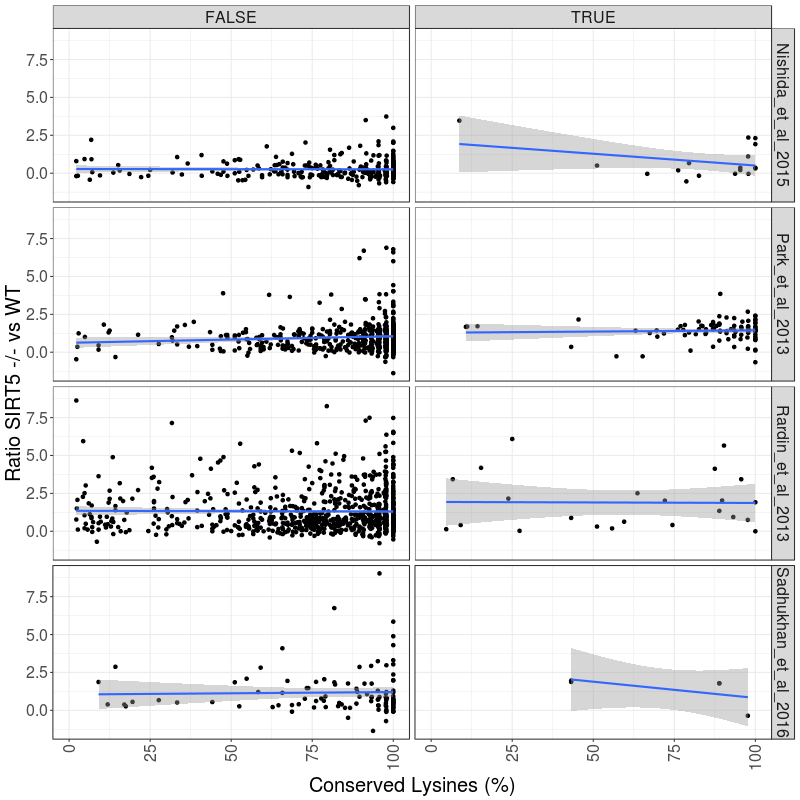

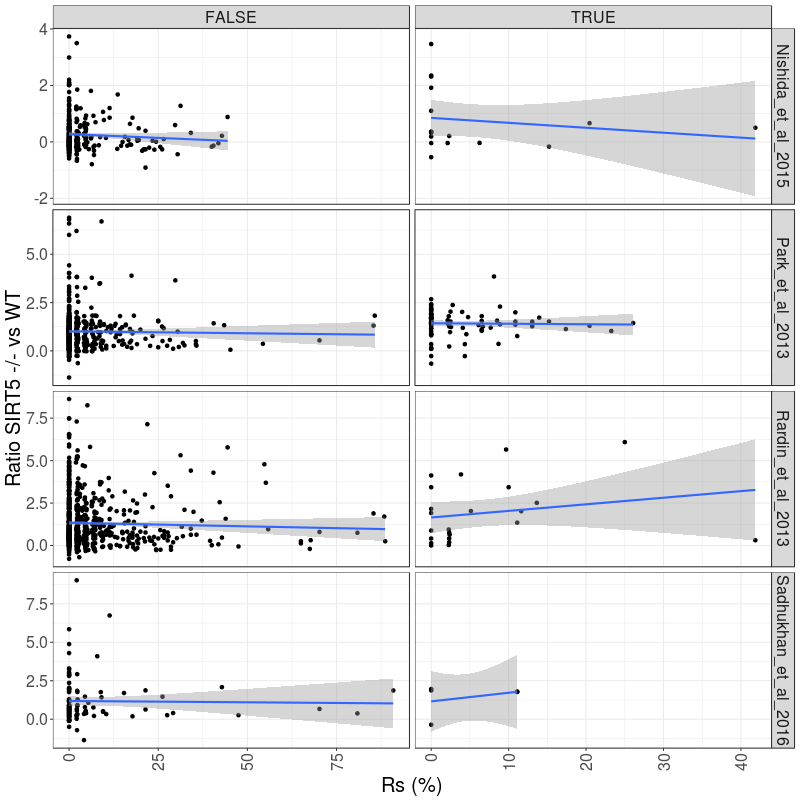

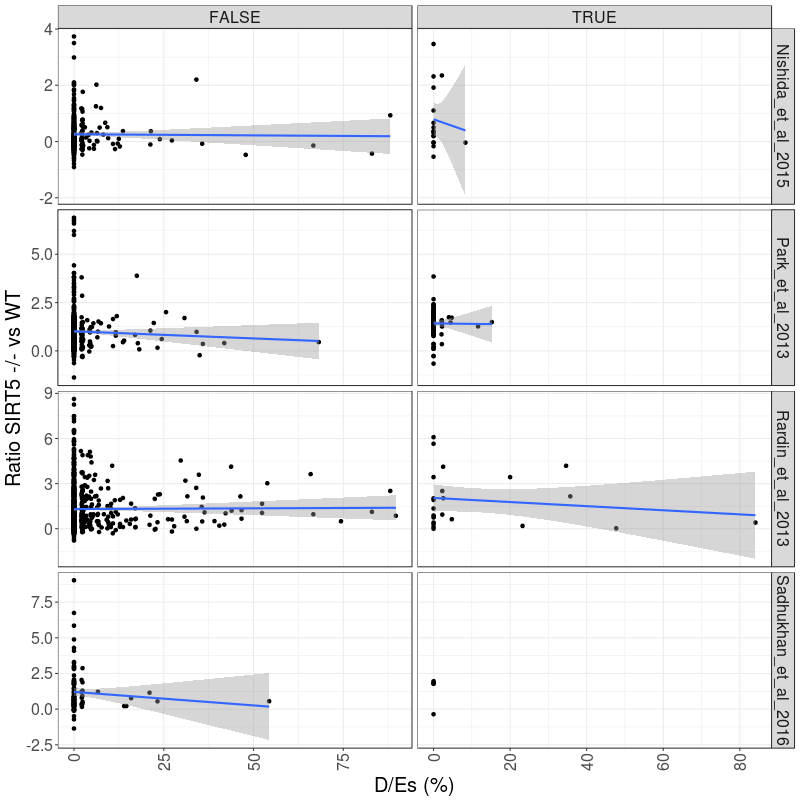

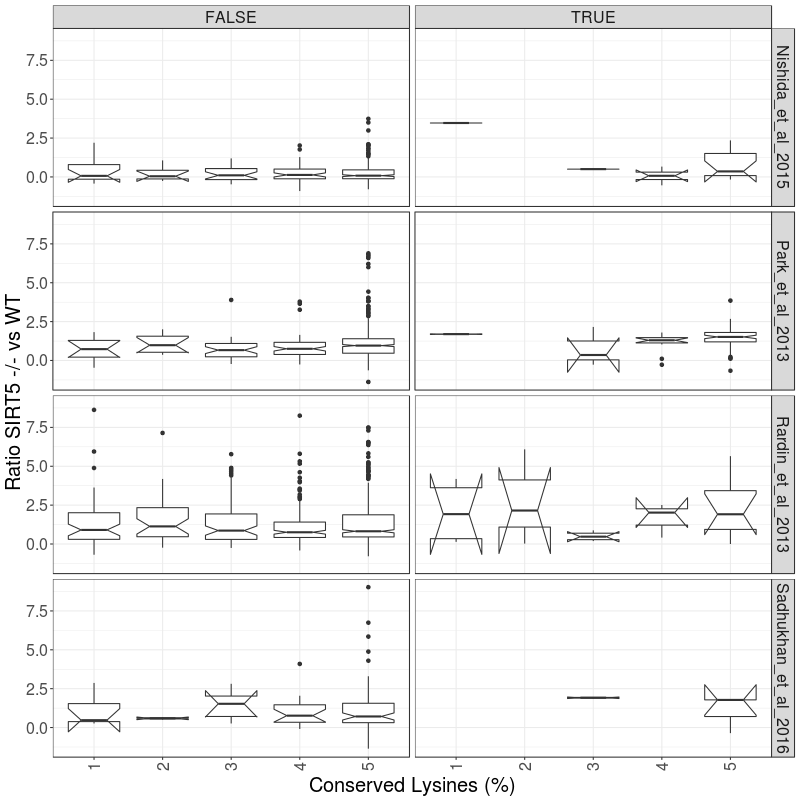

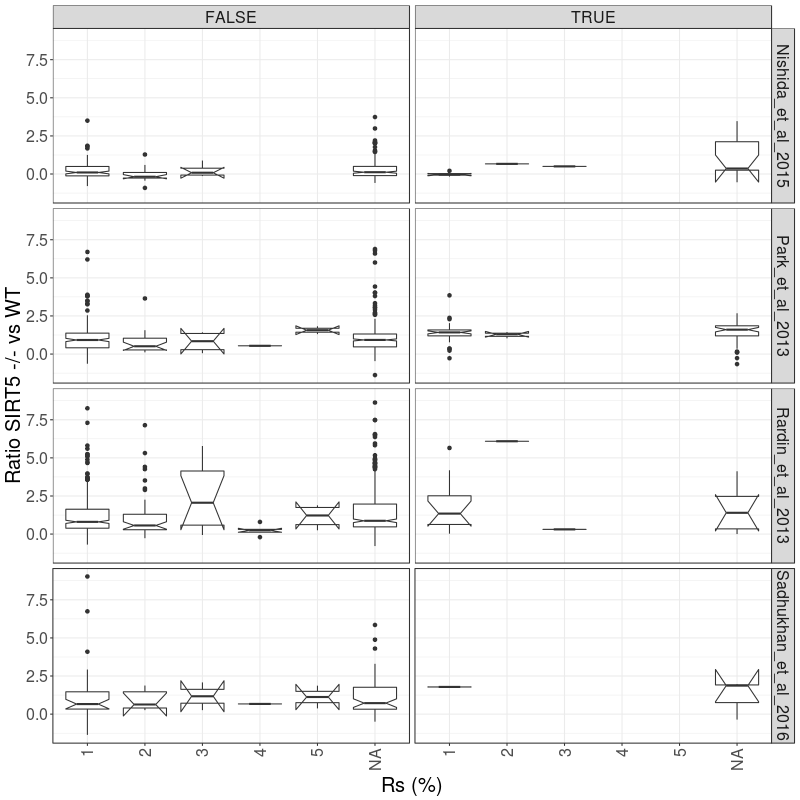

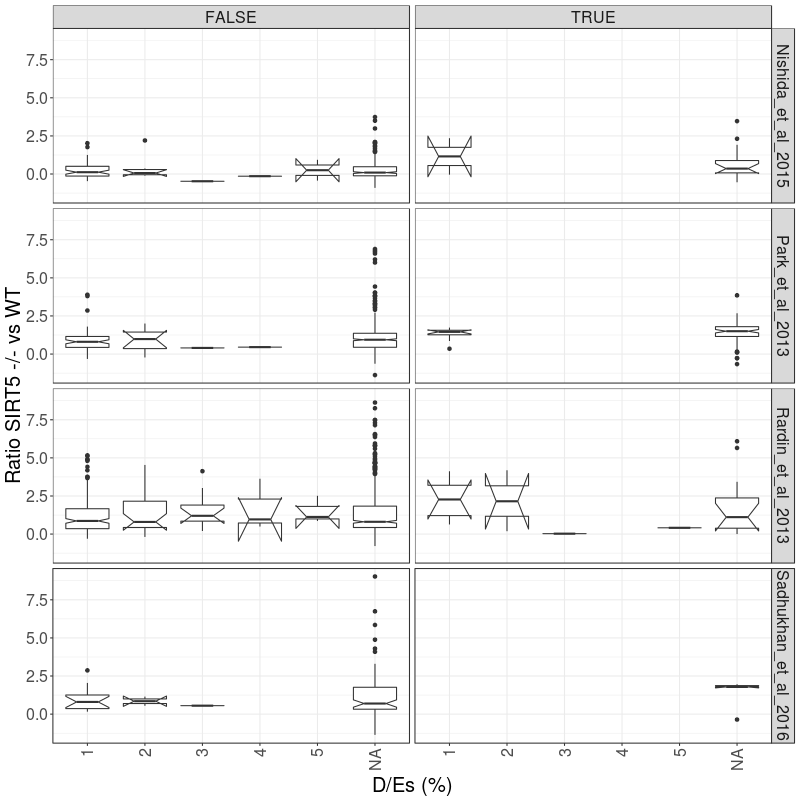

In [102]:
%%R -i base_counts_df -w 800 -h 800
library(ggplot2)

base_counts_df$ratio <- as.numeric(as.character(base_counts_df$ratio))

base_counts_df$K_conservation = (100*base_counts_df$K) / (base_counts_df$total - base_counts_df$missing)
base_counts_df$R_conversion = (100*base_counts_df$R) / (base_counts_df$total - base_counts_df$missing)
base_counts_df$DE_conversion = (100*(base_counts_df$D + base_counts_df$E) /
                 (base_counts_df$total - base_counts_df$missing))
base_counts_df$binned_K_conservation <- .bincode(base_counts_df$K_conservation, breaks = seq(0,100,20))
base_counts_df$binned_DE_conservation <- .bincode(base_counts_df$DE_conversion, breaks = seq(0,100,20))
base_counts_df$binned_R_conservation <- .bincode(base_counts_df$R_conversion, breaks = seq(0,100,20))

print(head(base_counts_df))

m_txt <- element_text(size=20)
my_theme <- theme(
    text=m_txt,
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

p <- ggplot(base_counts_df, aes(K_conservation, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("Conserved Lysines (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(R_conversion, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(reference~in_idr, scales='free') +
theme_bw() +
xlab("Rs (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(DE_conversion, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(reference~in_idr, scales='free') +
theme_bw() +
xlab("D/Es (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(factor(binned_K_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("Conserved Lysines (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(factor(binned_R_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("Rs (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)
p <- ggplot(base_counts_df, aes(factor(binned_DE_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("D/Es (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)


In [21]:
def isInGroup(tax_id, group):
    '''unfortunately yhe ncbi.get_descendant function from ete doesn't
    retrieve all descendants. For example 9606 (homo sapien) is not in vertebrates!
    
    This function tests if the group is in the tax_id lineage'''
    return group in ncbi.get_lineage(tax_id)

print(isInGroup(9606, vertebrate_tax_id))
print(isInGroup(9606, mammals_tax_id))
print(isInGroup(9606, placentals_tax_id))
print(isInGroup(28377, vertebrate_tax_id)) #green Anole
print(isInGroup(28377, mammals_tax_id)) #green Anole
print(isInGroup(28377, placentals_tax_id)) #green Anole

True
True
True
True
False
False


In [22]:
mammal_ids = set()
non_mammal_ids = set()

placental_ids = set()
non_placental_ids = set()

rodent_rabit_ids = set()
non_rodent_rabit_ids = set()
print(10090 in species)
print(9601 in species)
for organism in species:
    
    if isInGroup(organism, mammals_tax_id):
        mammal_ids.add(organism)
    else:
        non_mammal_ids.add(organism)
    
    if isInGroup(organism, placentals_tax_id):
        placental_ids.add(organism)
    else:
        non_placental_ids.add(organism)
        
    if isInGroup(organism, rodent_tax_id):
        rodent_rabit_ids.add(organism)
    else:
        non_rodent_rabit_ids.add(organism)
        
        
print("10090" in mammal_ids)
print("10090" in non_mammal_ids)

print("9601" in mammal_ids)
print("9601" in non_mammal_ids)


True
True
False
False
False
False


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:224: UserWarning: taxid 994 was translated into 986
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [23]:
n = 0 

rows = []

for uniprot_id in alignments.keys():
    positions_covered = set()
    #if n>=5:
    #    break
    #print(uniprot_id)
    for position in alignments[uniprot_id]:

        tmp_alignments = alignments[uniprot_id][position].split("\n")
        
        tmp_alignment_tax_ids = [x[1:] for x in tmp_alignments[::2]]
        tmp_alignment_tax_seq = [x[1:] for x in tmp_alignments[1::2]]
        tmp_alignments_dict = {int(x):y for x, y in zip(tmp_alignment_tax_ids, tmp_alignment_tax_seq)}
        
        seq_ix = -11
        for ix, base in enumerate(tmp_alignments_dict[10090], -10):
            if not base == "-":
                seq_ix += 1
            if base == "K":
                if position+ix not in positions_covered:
                    positions_covered.add(position+ix)

                    k_mammals = 0
                    k_non_mammals = 0
                    non_k_mammals = 0
                    non_k_non_mammals = 0
                    de_mammals = 0
                    de_non_mammals = 0
                    non_de_mammals = 0
                    non_de_non_mammals = 0
                    r_all = 0
                    total = 0

                    #print(tmp_alignments_dict)
                    for tax_id in tmp_alignments_dict:

                        seq = tmp_alignments_dict[tax_id]
                        mammal = tax_id in mammal_ids
                        
                        tax_id_base = seq[ix + 10]

                        try:
                            if tax_id_base == "-":
                                pass
                            else:
                                total += 1
                                if tax_id_base == "K":
                                    if mammal:
                                        k_mammals += 1
                                        non_de_mammals += 1
                                    else:
                                        k_non_mammals += 1
                                        non_de_non_mammals += 1

                                elif tax_id_base == "D" or tax_id_base == "E":
                                    if mammal:
                                        de_mammals += 1
                                        non_k_mammals += 1
                                    else:

                                        de_non_mammals += 1
                                        non_k_non_mammals += 1

                                elif tax_id_base == "R":
                                    r_all += 1

                                else:
                                    if mammal:
                                        non_k_mammals += 1
                                        non_de_mammals += 1
                                    else:
                                        non_k_non_mammals += 1
                                        non_de_non_mammals += 1
                        except:
                            print(tmp_alignments_dict)
                            print(seq, tax_id, position+ix)
                            print(k_mammals, k_non_mammals)
                            print(uniprot_id)
                            print(alignments[uniprot_id][position])
                            raise ValueError()

                    rows.append((uniprot_id, position+seq_ix,
                                 position+seq_ix in alignments[uniprot_id],
                                 k_mammals, k_non_mammals,
                                 non_k_mammals, non_k_non_mammals,
                                 de_mammals, non_de_mammals,
                                 de_non_mammals, non_de_non_mammals,
                                 r_all, total))


In [24]:
header = ("uniprot_id", "position", "succ.lysine",
          "k_mammals","k_non_mammals",
          "non_k_mammals", "non_k_non_mammals",
          "de_mammals", "non_de_mammals",
          "de_non_mammals", "non_de_non_mammals",
          "r_all", "total")

df = pd.DataFrame.from_records(rows, columns=header)
df = pd.merge(df, ratio_df, left_on=["uniprot_id", "position"], right_on=["uniprot_id", "position"],
              how='left')

df['fraction_k_mammals'] = df['k_mammals'] / (df['k_mammals'] + df['non_k_mammals'])
df['fraction_k_non_mammals'] = df['k_non_mammals'] / (df['k_non_mammals'] + df['non_k_non_mammals'])
df['fraction_de_non_mammals'] = df['de_non_mammals'] / (df['de_non_mammals'] + df['non_de_non_mammals'])

df['fraction_de'] = ((df['de_mammals'] + df['de_non_mammals']) / df['total'])
df['fraction_k'] = ((df['k_mammals'] + df['k_non_mammals']) / df['total'])
df['fraction_r'] = df['r_all'] / df['total']

df['K_DE'] = ((df['fraction_de_non_mammals'] >= 0.6) & (df['fraction_k_mammals'] >= 0.8))
df.drop(["in_elm", "in_idr", "in_nls", "in_krepeats"], axis=1, inplace=True)
for column in ["modification", "reference"]:
    df[column] = df[column].astype(str)

print(df[df['uniprot_id']=='Q9D0K2'].head())
#
#print(df[df['uniprot_id']=='Q9EQ20'])
print(df.shape)
#df = df[df['fraction_k_non_mammals'].notnull()]
print(collections.Counter(df['de_non_mammals']))

print(df['succ.lysine'].value_counts())
df_kde = df[df['K_DE']==True]
print(df_kde['succ.lysine'].value_counts())

print(df_kde.shape)


     uniprot_id  position succ.lysine  k_mammals  k_non_mammals  \
3483     Q9D0K2       173       False         26             19   
3484     Q9D0K2       176        True         25             11   
3485     Q9D0K2       185        True         24              1   
3486     Q9D0K2       417       False         25             17   
3487     Q9D0K2       420       False         26             17   

      non_k_mammals  non_k_non_mammals  de_mammals  non_de_mammals  \
3483              1                  0           0              27   
3484              2                  7           0              27   
3485              2                 18           0              26   
3486              1                  0           0              26   
3487              0                  0           0              26   

      de_non_mammals  ...       ratio  p_value  len_repeats  \
3483               0  ...         NaN      NaN          NaN   
3484               0  ...    2.034067     -1.0    

  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     Q9DC69      157        TRUE        25             6             1
1     Q9DC69      175        TRUE        24             9             1
2     Q9DC69      179       FALSE         7            19             1
3     Q9DC69      184       FALSE        26            20             0
4     Q91VA0      352        TRUE        13             0             0
5     Q91VA0      541        TRUE        17             0             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 1          0             26              0                  7
1                 1          1             24              0                 10
2                 0          0              8              0                 19
3                 0          0             26              0                 20
4                 0          0             13              0                  0
5               

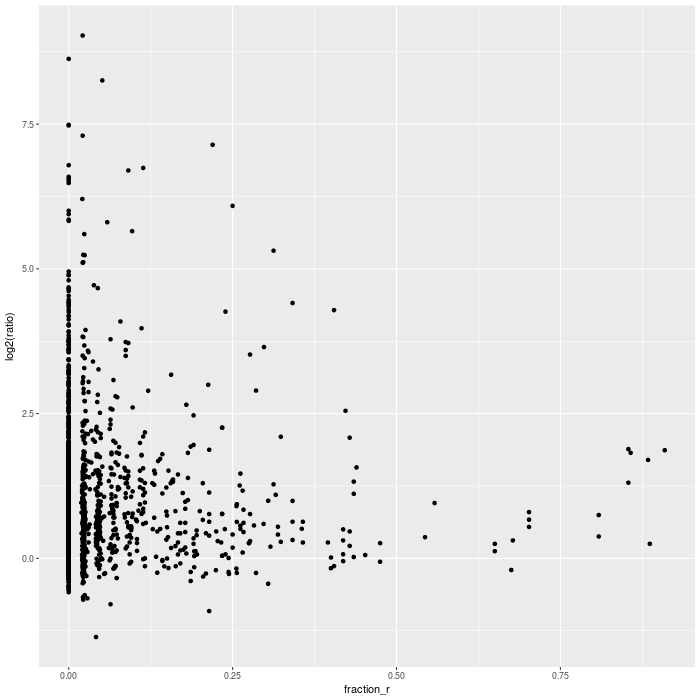

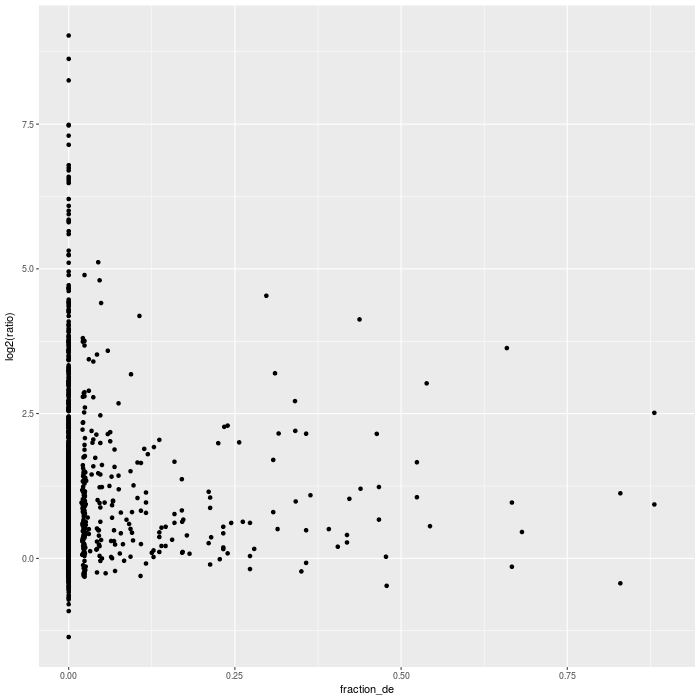

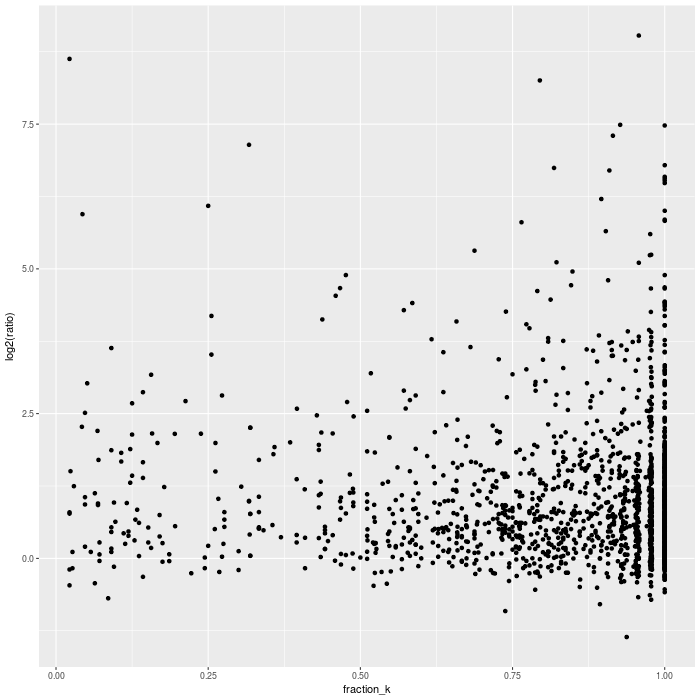

In [67]:
%%R -i df -w 700 -h 700
print(head(df))
p = ggplot(df, aes(fraction_r, log2(ratio))) + geom_point()
print(p)

p = ggplot(df, aes(fraction_de, log2(ratio))) + geom_point()
print(p)

p = ggplot(df, aes(fraction_k, log2(ratio))) + geom_point()
print(p)

  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     Q9DC69      157        TRUE        25             6             1
1     Q9DC69      175        TRUE        24             9             1
2     Q9DC69      179       FALSE         7            19             1
3     Q9DC69      184       FALSE        26            20             0
4     Q91VA0      352        TRUE        13             0             0
5     Q91VA0      541        TRUE        17             0             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 1          0             26              0                  7
1                 1          1             24              0                 10
2                 0          0              8              0                 19
3                 0          0             26              0                 20
4                 0          0             13              0                  0
5               

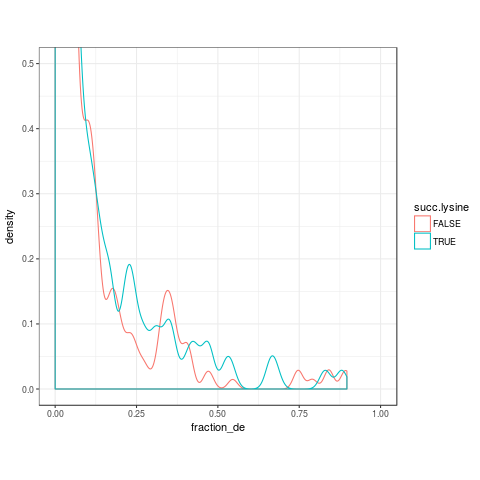

In [108]:
%%R -i df
print(head(df))
threshold = 0.1
print(table(ifelse(df$fraction_de > threshold, "de", "non_de"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_de > threshold, "de", "non_de"), df$succ.lysine)))


threshold = 0.1
print(table(ifelse(df$fraction_r > threshold, "r", "non_r"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_r > threshold, "r", "non_r"), df$succ.lysine)))


threshold = 0.05
print(table(ifelse(df$fraction_k > threshold, "k", "non_k"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_k > threshold, "k", "non_k"), df$succ.lysine)))


my_theme = theme(aspect.ratio=1)

p = ggplot(df, aes(col=succ.lysine, x=fraction_de))
p2 = p + geom_density() + coord_cartesian(xlim=c(0, 1), ylim=c(0,0.5)) +
theme_bw() + my_theme
                
print(p2)

  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     Q9DC69      157        TRUE        25             6             1
1     Q9DC69      175        TRUE        24             9             1
2     Q9DC69      179       FALSE         7            19             1
3     Q9DC69      184       FALSE        26            20             0
4     Q91VA0      352        TRUE        13             0             0
5     Q91VA0      541        TRUE        17             0             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 1          0             26              0                  7
1                 1          1             24              0                 10
2                 0          0              8              0                 19
3                 0          0             26              0                 20
4                 0          0             13              0                  0
5               

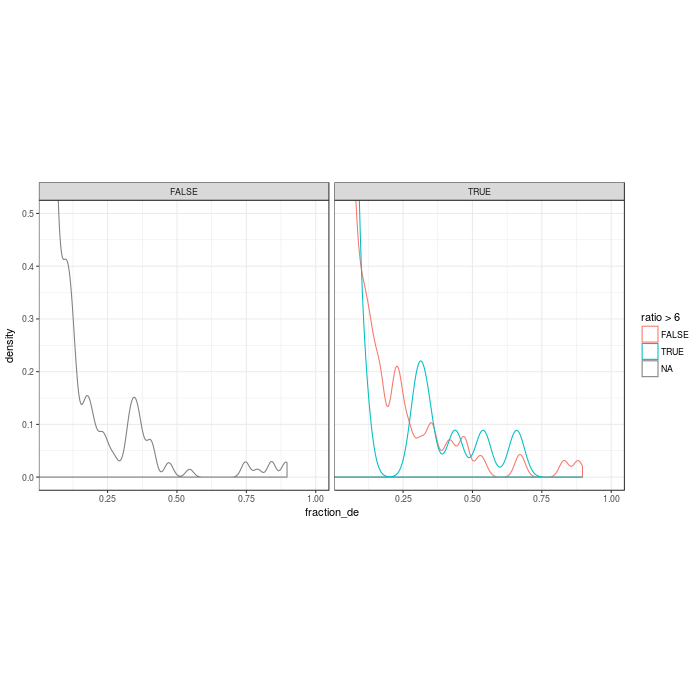

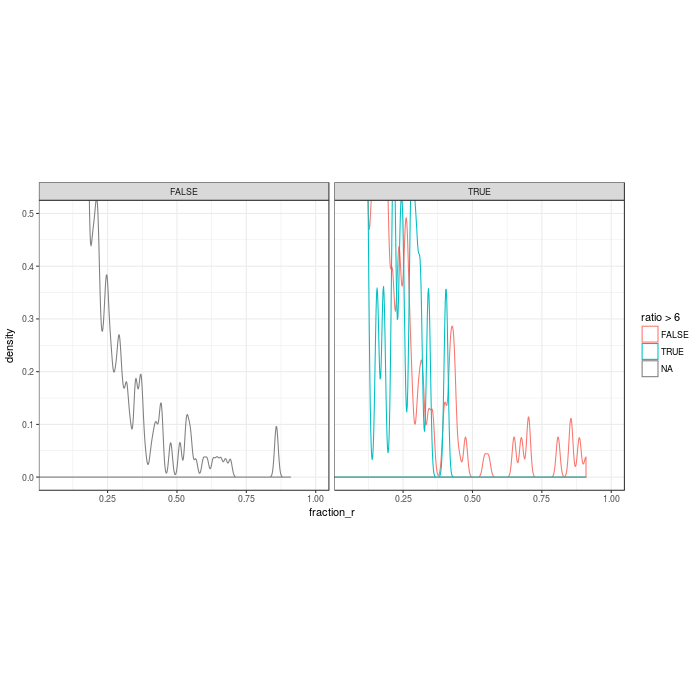

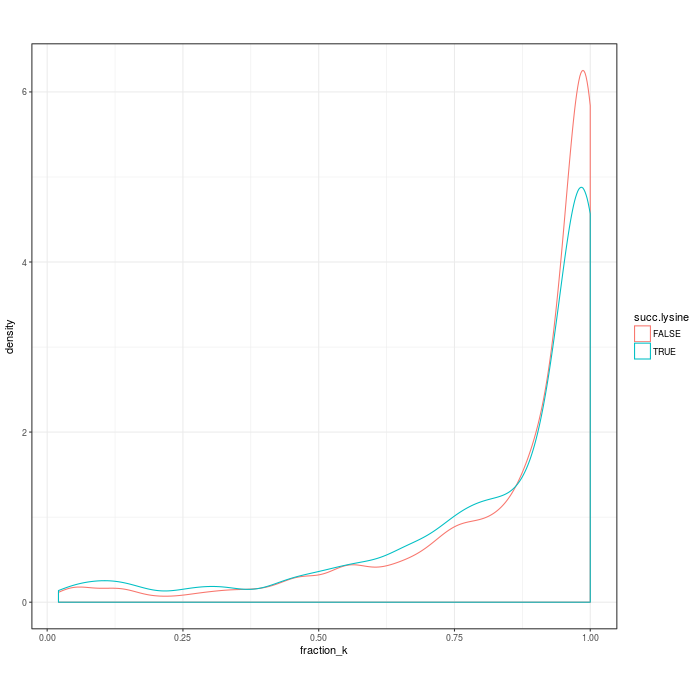

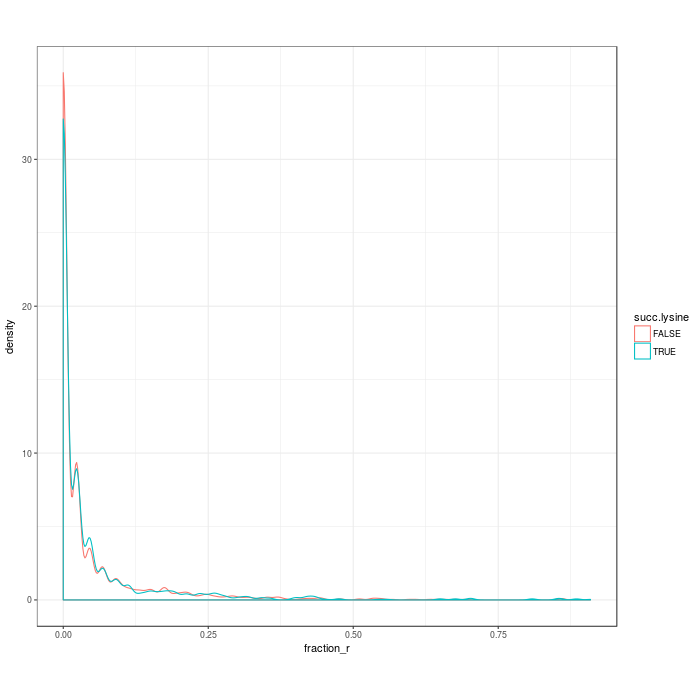

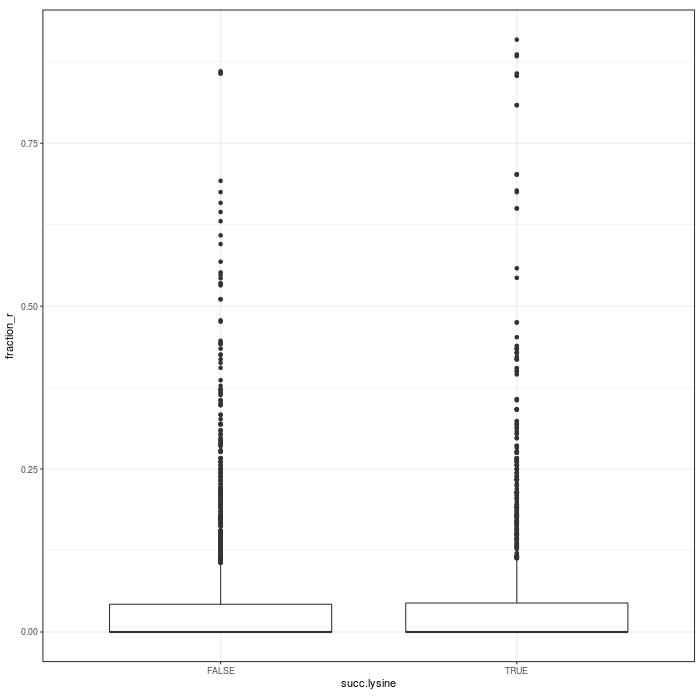

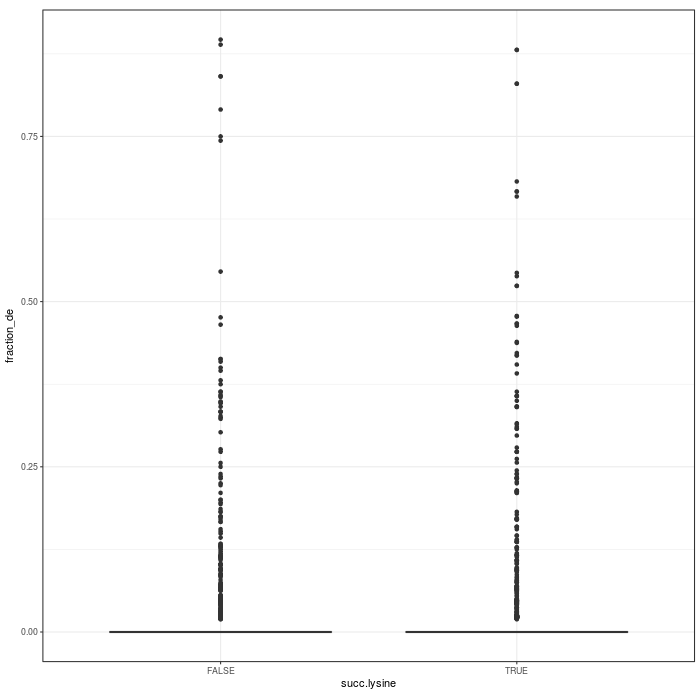

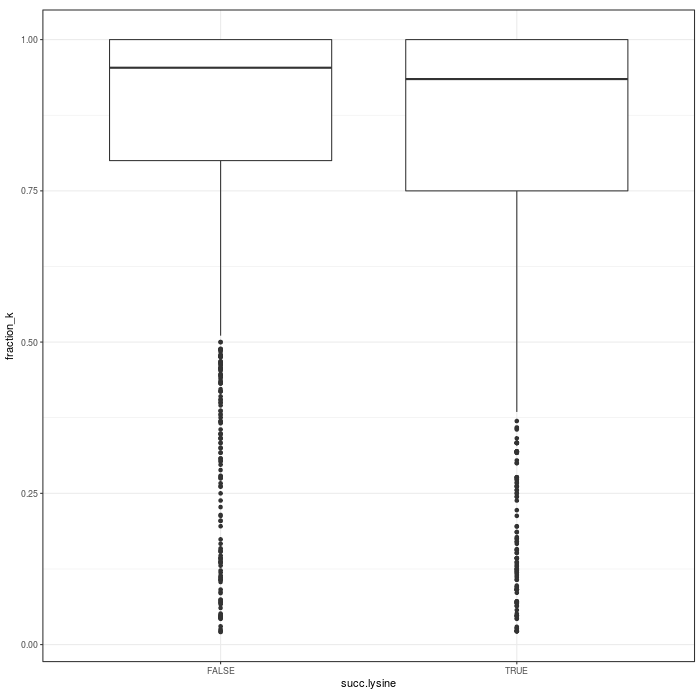

In [38]:
%%R -i df -w 700 -h 700
print(head(df))

my_theme = theme(aspect.ratio=1)

p = ggplot(df, aes(col=ratio>6, x=fraction_de))

p2 = p + geom_density() + coord_cartesian(xlim=c(0.05, 1), ylim=c(0,0.5)) + facet_wrap(~succ.lysine) +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(col=ratio>6, x=fraction_r))

p2 = p + geom_density() + coord_cartesian(xlim=c(0.05, 1), ylim=c(0,0.5)) + facet_wrap(~succ.lysine) +
theme_bw() + my_theme
                
                
print(p2)


p = ggplot(df, aes(col=succ.lysine, x=fraction_k))

p2 = p + geom_density()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(col=succ.lysine, x=fraction_r))

p2 = p + geom_density()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_r))

p2 = p + geom_boxplot()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_de))

p2 = p + geom_boxplot()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_k))

p2 = p + geom_boxplot()  +
theme_bw() + my_theme
                
print(p2)

In [27]:
#for uniprot_id in set(df['uniprot_id']):
print(outfile_aligned)
for uniprot_id in ["Q91V76"]:
    print("\n", uniprot_id)
    retained_uniprot_ids = uniprot2_121_orthologs[uniprot_id]
    
    outfile_aligned = "./results/conservation/fasta/%s_clustalo.fa" % uniprot_id
    print(outfile_aligned)
    
    for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
        tax_id_uniprot_id, tax_id = fasta.title.split("_")
        tax_id = int(tax_id.replace(";", ""))
        if tax_id_uniprot_id == uniprot_id:
            mouse_seq = fasta.sequence
            bases_array_mammals = np.zeros((len(aas), len(fasta.sequence)))
            bases_array_non_mammals = np.zeros((len(aas), len(fasta.sequence)))

        if tax_id in mammal_ids:
            for ix, base in enumerate(fasta.sequence):
                bases_array_mammals[(aas.index(base), ix)] += 1
        else:
            for ix, base in enumerate(fasta.sequence):
                bases_array_non_mammals[(aas.index(base), ix)] += 1

    seq_n = 0

    for ix, base in enumerate(mouse_seq):
        if base != "-":
            seq_n += 1

        fraction_k_non_mammals = (bases_array_non_mammals[aas.index("K"),ix] /
                      (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]))
        fraction_de_non_mammals = ((bases_array_non_mammals[aas.index("D"),ix] +
                                    bases_array_non_mammals[aas.index("E"),ix])/
                      (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]))

        fraction_k_mammals = (bases_array_mammals[aas.index("K"),ix] /
                      (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]))
        fraction_de_mammals = ((bases_array_mammals[aas.index("D"),ix] + bases_array_mammals[aas.index("E"),ix])/
                      (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]))

        #print(ix, base, fraction_k, fraction_de)

        if ((fraction_de_mammals > 0.5 and fraction_de_non_mammals < 0.2) and
            (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]) >= 10 and
            (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]) >= 5):
            
            pass

            print(fraction_de_mammals > 0.5, fraction_de_non_mammals < 0.5)
            print(ix, seq_n, base, fraction_de_mammals, fraction_de_non_mammals)
            print(bases_array_mammals[aas.index("D"),ix], bases_array_non_mammals[aas.index("D"),ix])
            print(bases_array_mammals[aas.index("E"),ix], bases_array_non_mammals[aas.index("E"),ix])
            print(print(bases_array_mammals[aas.index("E"),ix], bases_array_non_mammals[aas.index("E"),ix]))
            

            species = set()
            tmp_alignments = ""
            for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
                tax_id_uniprot_id, tax_id = fasta.title.split("_")
                tax_id = int(tax_id.replace(";", ""))
                if tax_id_uniprot_id in retained_uniprot_ids or tax_id_uniprot_id == uniprot_id:
                    species.add(tax_id)
                    tmp_alignments += ">%i\n%s\n" % (tax_id, fasta.sequence[ix-10: ix+10])

            tree = ncbi.get_topology(species, intermediate_nodes=False)
            tree.link_to_alignment(tmp_alignments)
            
            #tree.show()
                
            
            

./results/conservation/fasta/P20065_clustalo.fa

 Q91V76
./results/conservation/fasta/Q91V76_clustalo.fa


In [28]:
n = 0 

mammal_ids = set()
non_mammal_ids = set()

rows = []

for uniprot_id in alignments.keys():

    for position in alignments[uniprot_id]:
   
        k_organisms = amino_acids_at_K[uniprot_id][position]["K"]
        r_organisms = amino_acids_at_K[uniprot_id][position]["R"]
        de_organisms = amino_acids_at_K[uniprot_id][position]["D"]
        de_organisms.update(amino_acids_at_K[uniprot_id][position]["E"])
        organisms = set()
        for aa in aas:
            if aa != "-":
                organisms.update(amino_acids_at_K[uniprot_id][position][aa])
        non_k_organisms = organisms.difference(k_organisms)
        non_de_organisms = organisms.difference(de_organisms)
        non_r_organisms = organisms.difference(r_organisms)

        k_mammals = []
        k_non_mammals = []
        for x in k_organisms:
            if x in mammal_ids:
                k_mammals.append(x)
            elif x in non_mammal_ids:
                k_non_mammals.append(x)
            else:
                if isInGroup(x, mammals_tax_id):
                    k_mammals.append(x)
                    mammal_ids.add(x)
                else:
                    k_non_mammals.append(x)
                    non_mammal_ids.add(x)

        non_k_mammals = []
        non_k_non_mammals = []
        for x in non_k_organisms:
            if x in mammal_ids:
                non_k_mammals.append(x)
            elif x in non_mammal_ids:
                non_k_non_mammals.append(x)
            else:
                if isInGroup(x, mammals_tax_id):
                    k_mammals.append(x)
                    mammal_ids.add(x)
                else:
                    k_non_mammals.append(x)
                    non_mammal_ids.add(x)   
  
        de_mammals = []
        de_non_mammals = []
        for x in de_organisms:
            if x in mammal_ids:
                de_mammals.append(x)
            elif x in non_mammal_ids:
                de_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")
        
        r_mammals = []
        r_non_mammals = []
        for x in r_organisms:
            if x in mammal_ids:
                r_mammals.append(x)
            elif x in non_mammal_ids:
                r_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")
                
        non_k_mammals = []
        non_k_non_mammals = []
        for x in non_k_organisms:
            if x in mammal_ids:
                non_k_mammals.append(x)
            elif x in non_mammal_ids:
                non_k_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")

        non_de_mammals = []
        non_de_non_mammals = []
        for x in non_de_organisms:
            if x in mammal_ids:
                non_de_mammals.append(x)
            elif x in non_mammal_ids:
                non_de_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here2!")

        non_r_mammals = []
        non_r_non_mammals = []
        for x in non_r_organisms:
            if x in mammal_ids:
                non_r_mammals.append(x)
            elif x in non_mammal_ids:
                non_r_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here2!")
                
        if (len(k_non_mammals) + len(non_k_non_mammals)) == 0:
            print("No non mammals!", uniprot_id, position)
            continue

        fraction_k_mammal = (len(k_mammals) / ( len(non_k_mammals) + len(k_mammals)))
        fraction_k_non_mammal = (len(k_non_mammals) / ( len(non_k_non_mammals) + len(k_non_mammals)))

        fraction_de_mammal = (len(de_mammals) / ( len(non_de_mammals) + len(de_mammals)))
        fraction_de_non_mammal = (len(de_non_mammals) / ( len(non_de_non_mammals) + len(de_non_mammals)))

        fraction_r_mammal = (len(r_mammals) / ( len(non_r_mammals) + len(r_mammals)))
        fraction_r_non_mammal = (len(r_non_mammals) / ( len(non_r_non_mammals) + len(r_non_mammals)))
        
        row = [uniprot_id, position,
               fraction_k_mammal, fraction_k_non_mammal,
               fraction_de_mammal, fraction_de_non_mammal,
               fraction_r_mammal, fraction_r_non_mammal]
        
        tree = ncbi.get_topology(organisms, intermediate_nodes=False)
        tree.link_to_alignment(alignments[uniprot_id][position])
        #tree.show()
            
        if fraction_k_mammal > 0.8 and fraction_de_non_mammal > 0.4:
            row.append(1)
            print(uniprot_id, position)
            print(fraction_k_mammal)
            print(fraction_de_non_mammal)
            
            try:
                tree = ncbi.get_topology(k_organisms, intermediate_nodes=False)

                #print(dir(tree))
                #print(type(tree))
                print(tree.taxid)
                print(ncbi.translate_to_names([tree.taxid]))
                print(ncbi.get_common_names([tree.taxid]))
                ##print(tree.get_ascii(attributes=["sci_name", "rank"]))
            except:
                pass

            tree = ncbi.get_topology(organisms, intermediate_nodes=False)
            tree.link_to_alignment(alignments[uniprot_id][position])
            #tree.show()
            n+=1
            #tree.render("./results/conservation/plots/%s_%s.png" % (uniprot_id, position))
            #raise ValueError()
        else:
            row.append(0)
            
        if fraction_k_mammal > 0.8 and fraction_k_non_mammal < 0.2:
            row.append(1)
        else:
            row.append(0)

        rows.append(row)

No non mammals! Q91VA0 352
No non mammals! Q91VA0 545
No non mammals! Q91VA0 387
No non mammals! Q91VA0 324
No non mammals! Q91VA0 534
No non mammals! Q91VA0 200
No non mammals! Q91VA0 249
No non mammals! Q91VA0 252
No non mammals! Q91VA0 541
No non mammals! Q91VA0 142
No non mammals! Q91VA0 527


Duplicated entry [9940] was renamed to [1_9940]


No non mammals! P26443 84
No non mammals! P26443 545
No non mammals! P52480 498
No non mammals! Q91XE0 113
No non mammals! Q91XE0 151
No non mammals! Q8K2B3 179
No non mammals! P42125 283
No non mammals! Q9D6R2 336
No non mammals! Q9D6R2 100
No non mammals! Q9CR57 189


Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]


P97379 392
1.0
1.0
10090
['Mus musculus']
{10090: 'house mouse'}
No non mammals! P63158 157
No non mammals! Q64737 156
No non mammals! Q9DCY0 150
No non mammals! Q9CQN1 426
No non mammals! P17182 80
No non mammals! P32020 491
No non mammals! O55125 146
No non mammals! P47915 112
No non mammals! P47915 145
No non mammals! P47915 151
No non mammals! P47915 134
No non mammals! P17742 44
No non mammals! Q8VDD5 1209
No non mammals! Q60932 279
No non mammals! Q9DB20 192
No non mammals! Q922Q1 66
No non mammals! P11725 292
P10853 109
1.0
1.0
10090
['Mus musculus']
{10090: 'house mouse'}
No non mammals! P20152 188
No non mammals! Q9DCX2 48
Q9DCX2 149
0.8888888888888888
0.6
40674
['Mammalia']
{40674: 'mammals'}
No non mammals! Q9DCX2 25
No non mammals! P03930 48
No non mammals! P03930 46
No non mammals! P03930 54


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:224: UserWarning: taxid 994 was translated into 986
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
Warnning: [1] terminal nodes could not be found in the alignment.
Warnning: [1] terminal nodes could not be found in the alignment.


Q8CHT0 551
1.0
1.0
10090
['Mus musculus']
{10090: 'house mouse'}


In [29]:
header = ["uniprot_id", "position",
          "fraction_k_mammal", "fraction_k_non_mammal",
          "fraction_de_mammal", "fraction_de_non_mammal",
          "fraction_r_mammal", "fraction_r_non_mammal",
          'succ._dep._charge', 'mammal_specific_k']

conservation_changes_df = pd.DataFrame.from_records(rows, columns = header)
conservation_changes_df = pd.merge(
    conservation_changes_df, ratio_df,
    left_on=["uniprot_id", "position"], right_on=["uniprot_id", "position"],
    how='left')
conservation_changes_df.drop('in_elm', axis=1, inplace=True)
print(conservation_changes_df.head())
conservation_changes_df.to_csv("./results/conservation/change_df.tsv",sep="\t", index=False)

  uniprot_id  position  fraction_k_mammal  fraction_k_non_mammal  \
0     Q9DC69       157           0.509804               0.500000   
1     Q9DC69       175           0.038462               0.000000   
2     O09111        43           1.000000               0.000000   
3     Q8C5H8        64           0.058824               0.000000   
4     P51410        59           0.037037               0.045455   

   fraction_de_mammal  fraction_de_non_mammal  fraction_r_mammal  \
0            0.000000                     0.0                0.0   
1            0.000000                     0.0                0.0   
2            0.000000                     0.0                0.0   
3            0.000000                     0.0                0.0   
4            0.962963                     1.0                0.0   

   fraction_r_non_mammal  succ._dep._charge  mammal_specific_k   modification  \
0                    0.0                  0                  0  succinylation   
1                   

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


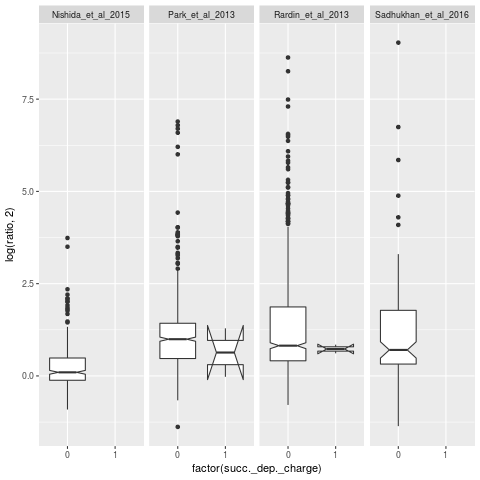

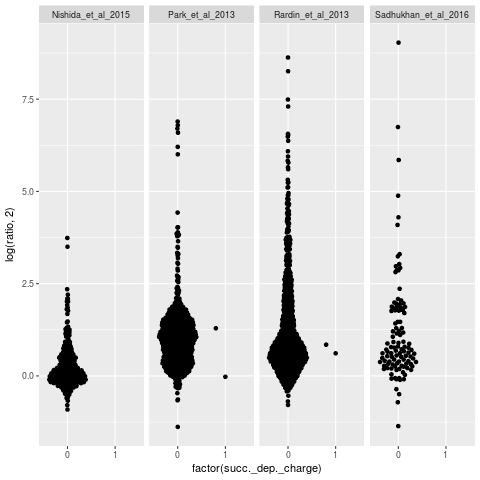

In [30]:
%%R -i conservation_changes_df
library(ggplot2)

df <- conservation_changes_df[order(-conservation_changes_df$succ._dep._charge),]

p = ggplot(df, aes(factor(succ._dep._charge), log(ratio, 2))) +
facet_grid(.~reference)

p2 = p + geom_boxplot(notch=T)
print(p2)

p2 = p + geom_quasirandom()
print(p2)




In [31]:
%%R
tmp_df = df[df$reference=='Rardin_et_al_2013',]
print(table(tmp_df$p_value<0.001, tmp_df$mammal_specific_k))
print(table(tmp_df$p_value<0.001, tmp_df$succ._dep._charge))
print(table(tmp_df$p_value<0.001, tmp_df$fraction_k_non_mammal>0.7))

       
          0   1
  FALSE 477   7
  TRUE  340   3
       
          0   1
  FALSE 482   2
  TRUE  343   0
       
        FALSE TRUE
  FALSE   470   14
  TRUE    331   12


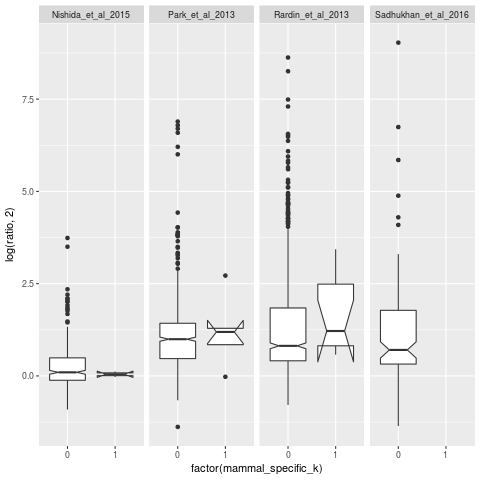

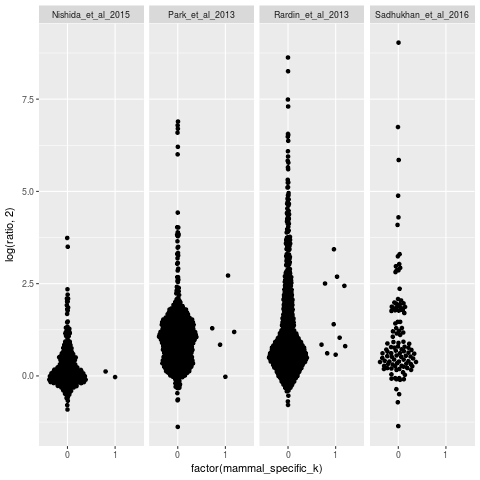

In [32]:
%%R
p = ggplot(df, aes(factor(mammal_specific_k), log(ratio, 2))) +
facet_grid(.~reference)

p2 = p + geom_boxplot(notch=T)
print(p2)

p2 = p + geom_quasirandom()
print(p2)

In [33]:
# show a specific uniprot id and position tree + alignment

uniprot_id = 'Q9D0K2'
position = 185

k_organisms = amino_acids_at_K[uniprot_id][position]["K"]       

organisms = set()
for aa in aas:
    if aa != "-":
        organisms.update(amino_acids_at_K[uniprot_id][position][aa])

non_k_organisms = organisms.difference(k_organisms)

tree = ncbi.get_topology(organisms, intermediate_nodes=False)
tree.link_to_alignment(alignments[uniprot_id][position])
n+=1
#tree.show()


In [34]:
n = 0 
for uniprot_id in alignments.keys():
    #print(uniprot_id)
    for position in alignments[uniprot_id]:
        k_organisms = amino_acids_at_K[uniprot_id][position]["K"]       
        organisms = set()
        for aa in aas:
            if aa != "-":
                organisms.update(amino_acids_at_K[uniprot_id][position][aa])
        non_k_organisms = organisms.difference(k_organisms)
        
        tree = ncbi.get_topology(organisms, intermediate_nodes=False)
        tree.link_to_alignment(alignments[uniprot_id][position])

        tree.render("./results/conservation/plots/%s_%s.png" % (uniprot_id, position), )
        
        n+=1
        if n%20==0:
            print(n)


Duplicated entry [9940] was renamed to [1_9940]


20
40
60


Warnning: [16] terminal nodes could not be found in the alignment.


80
100
120
140
160
180
200
220
240
260


Warnning: [16] terminal nodes could not be found in the alignment.


280
300
320
340
360
380


Warnning: [16] terminal nodes could not be found in the alignment.


400
420
440
460
480


Warnning: [16] terminal nodes could not be found in the alignment.


500
520
540
560
580
600


Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]


620


Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]


640
660
680
700
720
740
760


Warnning: [16] terminal nodes could not be found in the alignment.


780
800
820
840
860
880
900
920
940


Warnning: [16] terminal nodes could not be found in the alignment.


960
980
1000
1020
1040
1060
1080
1100


Warnning: [16] terminal nodes could not be found in the alignment.


1120
1140


Warnning: [16] terminal nodes could not be found in the alignment.


1160
1180
1200


Warnning: [16] terminal nodes could not be found in the alignment.


1220


Warnning: [16] terminal nodes could not be found in the alignment.


1240
1260


Warnning: [16] terminal nodes could not be found in the alignment.


1280
1300
1320
1340
1360
1380
1400
1420
1440
1460


Warnning: [16] terminal nodes could not be found in the alignment.


1480
1500
1520
1540
1560


Warnning: [1] terminal nodes could not be found in the alignment.
Warnning: [1] terminal nodes could not be found in the alignment.


1580
1600
